In [1]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import pyeeg

from scipy import signal
from scipy.signal import (welch, medfilt, wiener,savgol_filter)
from scipy.integrate import simps

import matplotlib.pyplot as plt

#Keras

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (StratifiedKFold, KFold)

from sklearn.metrics import (accuracy_score, make_scorer, balanced_accuracy_score, roc_auc_score, mean_squared_error)

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional



seed=42
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)
dir_path = os.getcwd()
# https://en.wikipedia.org/wiki/Neural_oscillation
SAMPLE_PER_SEC = 128
SAMPLE_PER_RAT = 21600
DELTA_WAVE = [1, 4]
THETA_WAVE = [4, 8]
ALPHA_WAVE = [7.5, 12.5]
BETA_WAVE = [13, 30]
TOTAL_ENERGY = [0, 64]
# not used
LOW_GAMMA_WAVE = [30, 70]
HIGH_GAMMA_WAVE = [70, 150]

EPSILON =  0.0002
FILTER_WINDOW = 5

Using TensorFlow backend.


In [2]:
# LOAD THE FEATURES FROM CSV
X_train = pd.read_csv("features/all_combined_train.csv").values
y_train = np.ravel(pd.read_csv("features/all_combined_label.csv").values)
X_test = pd.read_csv("features/all_combined_test.csv").values

print("X train final shape -> ",X_train.shape)
print("X test final shape -> ",X_test.shape)
#Fit scaler on all data
X_total = np.concatenate((X_train, X_test))
print("X total shape -> ", X_total.shape)

scaler = StandardScaler().fit(X_total)

data_dim = X_train.shape[1]
timesteps = SAMPLE_PER_RAT
num_classes = 3
batch_size = 32

X train final shape ->  (64800, 49)
X test final shape ->  (43200, 49)
X total shape ->  (108000, 49)


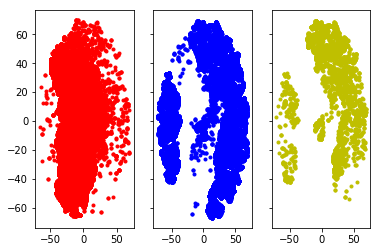

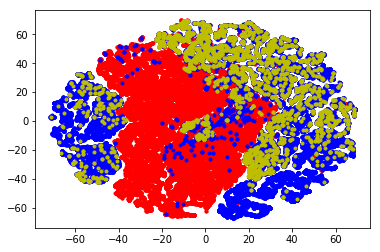

In [10]:
def plot_TSNE_clusters(X, y_train):
    N_SAMPLES = 64800
    random_index = np.random.choice(X.shape[0], N_SAMPLES)
    X = X[random_index, :]
    y_train = y_train[random_index]

    existing_2d = TSNE(n_components=2).fit_transform(X)
    awake_fold = existing_2d[y_train == 1]
    sleep_fold_nrem = existing_2d[y_train == 2]
    sleep_fold_rem = existing_2d[y_train == 3]

    f, (ax1, ax2, ax3) = plt.subplots(1, 3,  sharey=True)
    ax1.plot(awake_fold[:, 0], awake_fold[:, 1], 'r.')
    ax2.plot(sleep_fold_nrem[:, 0], sleep_fold_nrem[:, 1], 'b.')
    ax3.plot(sleep_fold_rem[:, 0], sleep_fold_rem[:, 1], 'y.')
    plt.show()

    plt.plot(awake_fold[:, 0], awake_fold[:, 1], 'r.')
    plt.plot(sleep_fold_nrem[:, 0], sleep_fold_nrem[:, 1], 'b.')
    plt.plot(sleep_fold_rem[:, 0], sleep_fold_rem[:, 1], 'y.')
    plt.show()
plot_TSNE_clusters(X_train, y_train)

In [ ]:
X_train_scaled = scaler.transform(X_train)
tsne_reducer = TSNE(n_components=3, 
                    random_state=seed, 
                    init="pca",
                    verbose=2)
tsne_reducer.fit(X_train_scaled)

In [3]:
X_total_scaled = scaler.transform(X_total)
tsne_reducer = TSNE(n_components=3, 
                    random_state=seed, 
                    init="pca",
                    verbose=2)
tsne_reducer.fit(X_total_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 108000 samples in 0.342s...
[t-SNE] Computed neighbors for 108000 samples in 918.940s...
[t-SNE] Computed conditional probabilities for sample 1000 / 108000
[t-SNE] Computed conditional probabilities for sample 2000 / 108000
[t-SNE] Computed conditional probabilities for sample 3000 / 108000
[t-SNE] Computed conditional probabilities for sample 4000 / 108000
[t-SNE] Computed conditional probabilities for sample 5000 / 108000
[t-SNE] Computed conditional probabilities for sample 6000 / 108000
[t-SNE] Computed conditional probabilities for sample 7000 / 108000
[t-SNE] Computed conditional probabilities for sample 8000 / 108000
[t-SNE] Computed conditional probabilities for sample 9000 / 108000
[t-SNE] Computed conditional probabilities for sample 10000 / 108000
[t-SNE] Computed conditional probabilities for sample 11000 / 108000
[t-SNE] Computed conditional probabilities for sample 12000 / 108000
[t-SNE] Computed conditional proba

TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=3, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=42, verbose=2)

In [5]:
X_train = tsne_reducer.embedding_[:64800,:]
X_test = tsne_reducer.embedding_[64800:,:]
print(X_train.shape)
print(X_test.shape)

(64800, 3)
(43200, 3)


In [6]:
# class weights
classes = np.array([1,2,3])
weights = compute_class_weight("balanced", classes, y_train)
cw = dict(zip(classes, weights))

# classifiers for CV
rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, verbose=False, class_weight = cw)
svc = SVC(class_weight="balanced", 
          random_state=seed, 
          C=0.01,
          verbose=True,
          gamma=0.0003)
kernel = 1.0 * RBF(1.0)
gbc = GradientBoostingClassifier(random_state=seed)
abc = AdaBoostClassifier(random_state=seed)
classifiers = [abc, gbc,  svc]
classifiers_names = [ "GradientBoostingClassifier", "AdaBoostClassifier", "SVC"]

# CROSS VALDATION
kfold = KFold(n_splits=3, shuffle=False, random_state=seed)

print("Start")

clf_scores_avg = []
clf_scores_std = []
for clf in classifiers:
    bmac_scores = []
    for train, valid in kfold.split(X_train):
        # get the folds
        X_train_fold = X_train[train]
        y_train_fold = y_train[train]

        X_valid_fold = X_train[valid]
        y_valid_fold = y_train[valid]

        #X_train_fold_scaled = scaler.transform(X_train_fold)
        #X_valid_fold_scaled = scaler.transform(X_valid_fold)

        # fit classifier
        clf.fit(X_train_fold, y_train_fold)

        y_pred = clf.predict(X_valid_fold)
        
        #remove impossible 
        #y_pred = remove_impossible_transitions(y_pred)
        
        # median filter
        y_pred = medfilt(y_pred, FILTER_WINDOW)
        

        bmac_score_rf = balanced_accuracy_score(y_valid_fold, y_pred)
        print(f"{len(bmac_scores)}: current balanced_accuracy_score: {bmac_score_rf}")

        bmac_scores.append(bmac_score_rf)
    
    clf_scores_avg.append(np.mean(bmac_scores))
    clf_scores_std.append(np.std(bmac_scores))

print("================================================================================")
for i in range(len(classifiers)):
    print(f"{classifiers_names[i]} BMAC avg score {clf_scores_avg[i]} +/- {clf_scores_std[i]}" )

print("================================================================================")
print("================================================================================")

print("DEFAULT 0.924203064567119 +/- 0.026768125976249342")
print("GAMMA = 0.0004 0.9401296487697763 +/- 0.02925282597198205")
print("GAMMA = 0.0004 C=0.1 0.9434637293201353 +/- 0.0257096513820207")
print("GAMMA = 0.0004 C=0.01 0.930809065681996 +/- 0.022307773367821106")

Start
0: current balanced_accuracy_score: 0.839332503501808
1: current balanced_accuracy_score: 0.8664219295348431
2: current balanced_accuracy_score: 0.9043956900298012
0: current balanced_accuracy_score: 0.8668403903212399
1: current balanced_accuracy_score: 0.9234193860954588
2: current balanced_accuracy_score: 0.9565898600004173
[LibSVM]0: current balanced_accuracy_score: 0.9131314418803228
[LibSVM]1: current balanced_accuracy_score: 0.8583321096489002
[LibSVM]2: current balanced_accuracy_score: 0.9042148918673619
GradientBoostingClassifier BMAC avg score 0.8700500410221509 +/- 0.02668553859324511
AdaBoostClassifier BMAC avg score 0.915616545472372 +/- 0.03705316062331135
SVC BMAC avg score 0.8918928144655283 +/- 0.02400856648330679
DEFAULT 0.924203064567119 +/- 0.026768125976249342
GAMMA = 0.0004 0.9401296487697763 +/- 0.02925282597198205
GAMMA = 0.0004 C=0.1 0.9434637293201353 +/- 0.0257096513820207
GAMMA = 0.0004 C=0.01 0.930809065681996 +/- 0.022307773367821106


In [ ]:
#Scale, fit, predict
svc = SVC(class_weight="balanced", random_state=seed, gamma=0.0004, C=0.1)
svc.fit(X_train, y_train)

In [12]:
y_pred_filtered = svc.predict(X_test)
# CORRECT all  predictions 1 to 3
#y_pred_filtered = remove_impossible_transitions(y_pred_filtered)

#  medfilt, wiener,savgol_filter
y_pred_filtered = medfilt(y_pred_filtered, FILTER_WINDOW)

(43200, 3)


Class 1: 18425
Class 2: 22287
Class 3: 2488


'\nClass 1: 23933\nClass 2: 18553\nClass 3: 714\n'

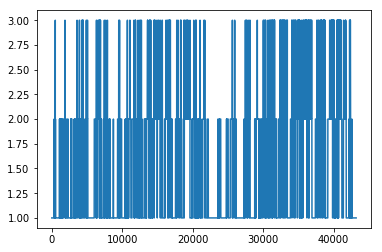

In [13]:
submission_name = "ax_TSNE.csv"

print(f"Class 1: {np.sum(y_pred_filtered == 1)}")
print(f"Class 2: {np.sum(y_pred_filtered == 2)}")
print(f"Class 3: {np.sum(y_pred_filtered == 3)}")

y_pred_df = pd.DataFrame(y_pred_filtered)
y_pred_df = y_pred_df.assign(Id=list(range(y_pred_filtered.shape[0])))
y_pred_df.columns = ['y', 'Id']
y_pred_df["y"].plot()
submission_folder = os.path.join(dir_path,"submissions/")
csv_file = submission_folder + submission_name

with open(csv_file, 'w') as csv:
    y_pred_df.to_csv(csv,index = False)
"""
Class 1: 23933
Class 2: 18553
Class 3: 714
"""